In [1]:
import numpy as np

import importlib
import os, sys
sys.path.append(os.path.abspath(".."))

In [2]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

## Options

A **call option** is a financial contract giving the holder the right, but not the obligation, to buy an asset at a predetermined price \(K\) (the strike price) at a specified future time $T$ (the maturity).

The payoff of a **European call option** at maturity depends on the terminal stock price \(S_T\):

$$
\text{Payoff at } T: (S_T - K)^+ = \max(S_T - K, 0)
$$

- If $S_T > K$, the option is **in the money**, and the holder profits $S_T - K$.  
- If $S_T \le K$, the option expires worthless.

<!-- Similarly, a **European put option** has payoff:

$$
\boxed{(K - S_T)^+ = \max(K - S_T, 0)}
$$ -->

The **option price today** is the discounted expected value of the payoff under the **risk-neutral measure** $\mathbb{Q}$:

$$
C(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(S_T - K)^+]%, \quad P(K) = e^{-r \tau} \mathbb{E}^{\mathbb{Q}}[(K - S_T)^+]
$$

where $\tau = T - t$.



## Heston Model

Before the implementation of the double Heston model, having a working implementation of the standard Heston model (Heston, 1993) is convenient.

In the Heston model the evolution of the stock price $S_t$ and its variance $v_t$ is defined by the following system of stochastic differential equations (under the risk neutral measure): 

$$
\begin{aligned}
d S_t &= (r-q) S_t dt + \sqrt v_t S_t d W_{1, t} \\
d v_t & = \kappa (\theta - v_t) dt + \sigma \sqrt v_t d W_{2, t},
\end{aligned}
$$
where  $W_{1,t}, W_{2,t}$ are Brownian motions, $E^{\mathbb{Q}}[dW_{1,t},dW_{2,t}]= \rho dt$ for the risk-neutral measure $\mathbb{Q}$ and

$r$: risk-free interest rate  
$q$: continuous dividend yield  
$\kappa >0$: mean reversion speed for the variance  
$\theta>0$: mean reversion level for the variance  
$\sigma > 0$: volatility of the variance  
$\rho \in [-1,1]$: correlation between $d W_{1,t}$ and $d W_{2,t}$

### Monte Carlo Simulations (Heston)

To calculate the price numerically, we use Monte Carlo simulations. In Monte Carlo pricing $S_T$ is obtained by simulating the underlying stochastic process (i.e. Heston SDE) up to maturity $N$ times, which results in $N$ stock price paths. The price is then calculated as the discounted average of the payoffs for all the paths. We use an Euler discretization for the system of SDEs.

#### Brownian Motions

In the Euler discretization we will have $dW_{1,t}$ and $dW_{2,t}$ corresponding to differences in time of the two Brownian motions. To guarantee that $dW_{1,t}$ and $dW_{2,t}$ have $\rho$ correlation as required by the model, we generate random variables $Z_1, Z_2 \sim \mathcal{N}(0,1)$, define
$$
\boxed{
\begin{aligned}
Z_V &= Z_1 \\
Z_S &= \rho Z_V + \sqrt {1-\rho^2} Z_2,
\end{aligned}
}
$$
and make
\begin{aligned}
dW_{1,t} &= \sqrt{dt} Z_S \\
dW_{2,t} &= \sqrt{dt} Z_V.
\end{aligned}

By construction, $E[Z_V]=E[Z_S]=0$ and therefore $E[Z_V Z_S]=\rho E[Z_1^2] + \sqrt{1-\rho^2} E[Z_1 Z_2]= \rho$

#### Euler Scheme (Heston)

Using Ito's lemma for the equation for the stock price yields in integral form
$$\ln S_{t+dt} = \ln S_t + \int_{t}^{t+dt} \left( r - q - \frac{1}{2} v_u \right) du + \int_{t}^{t+dt} \sqrt v_u d W_{1,u}$$.
The Euler discretization for the process $ln S_t$ is then
\begin{align}
\ln S_{t+dt} &\approx \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t (W_{1,t+dt} - W_{1,t}) \\
 & = \ln S_t + \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt v_t \sqrt{dt} Z_s.
\end{align}
From which we obtain
$$\boxed{S_{t+dt} = S_t \exp \left( \left( r - q - \frac{1}{2} v_t \right) dt + \sqrt{v_t} \sqrt{dt} Z_S \right).}$$

The integral form for the SDE for $v_t$ and corresponding Euler discretization are
\begin{align}
v_{t+dt} &= v_t + \int_{t}^{t+dt} \kappa (\theta - v_u) du + \int_{t}^{t+dt} \sigma \sqrt{v_u} dW_{2,u} \\
& \approx v_t+ \kappa (\theta -v_t) dt + \sigma \sqrt{v_t} (W_{2,t+dt}-W_{2,t}),
\end{align}
which gives the following Euler discretization for the variance
$$ \boxed{v_{t+dt} = v_t + \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} \sqrt{dt} Z_V}.$$

To avoid negative variances, we adopt the full truncation scheme, i.e. $v_t$ is replaced by $v_t^+= \max(0,v_t)$.

#### Monte Carlo Price

The Monte Carlo price is calculated using
$$\boxed{ C(K) = e^{-r \tau} \frac{1}{N} \sum_{i=1}^N \max(S^{(i)}_T-K,0) }$$
where $S^{(i)}_T$ is the terminal stock price in the stock price path $i=1, \ldots, N$.

### Exact price (Heston)

The price of a call option for the Heston model is given by the formula
$$\boxed{ C(K) = S_t e^{-q \tau} P_1 - K e^{-r \tau} P_2}$$
where 
$$ \boxed{ P _j = P(\ln S_T > K) = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty} \Re \left[\frac{e^{-i \phi \ln K} f_j (\phi; x_t,v_t)}{i \phi}\right] d \phi }$$.  
The functions $f_1, f_2$ are characteristic functions for the logarithm of the terminal stock price, $x_T = \ln S_T$:

$$\boxed{f_j(\phi; x_t,v_t) = \exp (C_j(\tau, \phi)+D_j(\tau, \phi) v_t+i \phi x_t),}$$
where $\tau = T-t$ is the time to maturity.

The expressions for $C_j(\tau, \phi)$ and $D_j(\tau, \phi)$ are
$$
\boxed{
\begin{align}
C_j (\tau, \phi) &= (r-q) i \phi \tau + \frac{\kappa \theta}{\sigma^2} \left[ (b_j - \rho \sigma i \phi - d_j) \tau - 2 \ln \left( \frac{1- c_j e^{-d_j \tau}}{1-c_j} \right) \right] \\
D_j(\tau, \phi) &= \frac{b_j - \rho \sigma i \phi-d_j}{\sigma^2} \left(\frac{1-e^{-d_j \tau}}{1-c_j e^{-d_j \tau}} \right).
\end{align}
}$$
Here, we have
$$
\boxed{
\begin{align}
c_j &= \frac{b_j - \rho \sigma i \phi - d_j}{b_j - \rho \sigma i \phi + d_j} \\
b_1 & = \kappa - \rho \sigma \\
b_2 &= \kappa \\
d_j &= \sqrt{(\rho \sigma i \phi - b_j)^2 - \sigma^2 (2 u_j i \phi - \phi^2)} \\
u_1 &= \frac{1}{2} \\
u_2 &=- \frac{1}{2}.
\end{align}
}
$$

These formulas use the Heston trap formulation for numerical stability. We take the principal branch of the complex root and logarithm in $d_j$ and $C_j$. The integral in $P_j$ is calculated numerically using the trapezoidal rule.

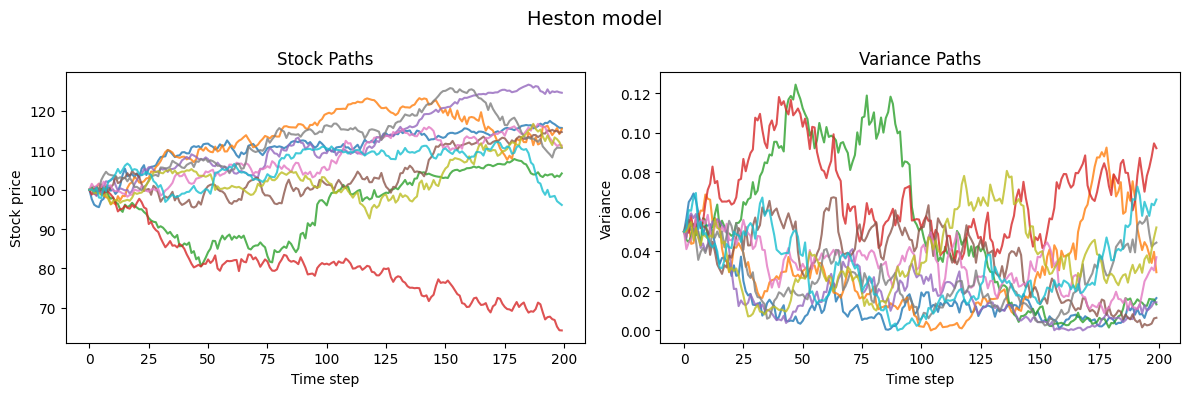

In [3]:
Heston_q_test=models.heston.Heston(r=0.03, q=0.02, 
                                 kappa=5.0, 
                                 theta=0.05, 
                                 sigma=0.5, 
                                 rho=-0.8)

S_hq_test, V_hq_test = Heston_q_test.simulate_paths(mu=Heston_q_test.r,T=0.5, S0=100, v0=0.05,
                                                    N_paths=10,N_steps=200, 
                                                    seed=20)

plotting.plot_utils.plot_paths(S_hq_test,V_hq_test, title='Heston model')

In [4]:
Heston_q_test.mc_price(N_paths=50000, N_steps=200, 
                       K=100, T=0.5, S0=100, v0=0.05,seed=20)

np.float64(6.277166549025437)

In [5]:
# Compare with Rouah's book 6.2528
Heston_q_test.cf_price(Lphi=0.00001, Uphi=50, dphi=0.001, 
                       K=100, tau=0.5, S=100, v=0.05)

np.float64(6.25281899799581)

In [6]:
# Let us compare our greeks function with cf_price
Heston_q_test.price_greeks(Lphi=0.00001, Uphi=50, dphi=0.001, 
                           K=100, tau=0.5, S=100, v=0.05)

{'call_price': np.float64(6.25281899799581),
 'delta': np.float64(0.5995065126081102)}

In [7]:
# And with the vector implementation
Heston_q_test.price_greeks_vect(K=100, Tau=np.array([[0.5]]), S=np.array([[100]]), V=np.array([[0.05]]),
                               quad_rule='trapezoidal', quad_params={'Lphi':1e-5, 'Uphi':50, 'dphi':0.001})['Delta'][0][0]

np.float64(0.5995065126081102)

In [8]:
hedging_hq_test=utils.hedging.delta_hedge(mu=Heston_q_test.r, model=Heston_q_test, 
                                      K=100,T=0.5, S0=100, v0=0.05,
                                     N_paths=5, N_steps=200, seed=20)
# Warning: The simulation of the portfolio has no implementation for q!=0 yet

laguerre quadrature rule with parameters: nodes=32
-0.18915518717160698 1.2960694726412665


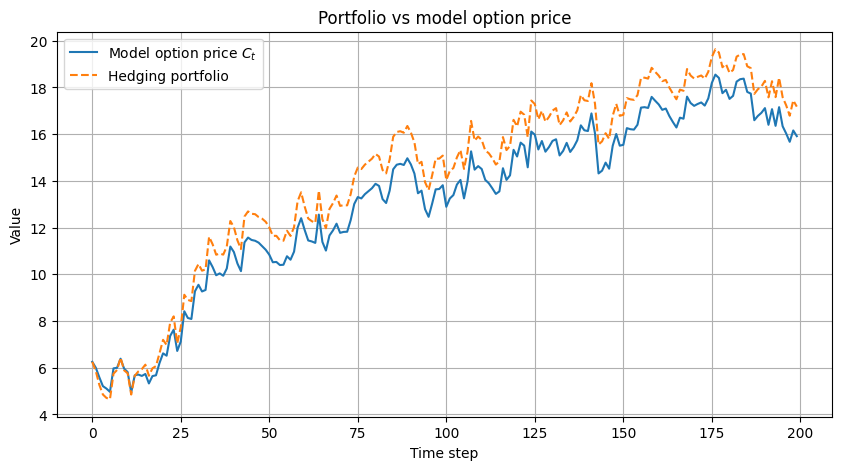

In [9]:
utils.hedging.hedge_plot(hedging_hq_test["Price_call"][0], hedging_hq_test["Portfolio"][0])

In [10]:
hedging_hq_test["Portfolio"][0], hedging_hq_test["Cash"][0]

(array([ 6.25267821,  5.85791663,  5.26557225,  4.85444172,  4.70808601,
         4.65172838,  5.74439057,  5.90359542,  6.428564  ,  5.88950842,
         5.76070865,  4.8512423 ,  5.65320033,  5.83937529,  5.93972182,
         6.13068878,  5.65721985,  5.97453899,  6.07147685,  6.62161053,
         7.19430182,  6.97158992,  7.92974051,  8.1989142 ,  7.03887127,
         7.73732473,  9.1246646 ,  8.90356063,  8.85278349, 10.14553798,
        10.43992416, 10.15497477, 10.20813773, 11.60807567, 11.2840865 ,
        10.838105  , 10.88864692, 10.84211815, 11.19334497, 12.28074751,
        12.02289465, 11.45346365, 11.08215241, 12.47402768, 12.69245733,
        12.59133612, 12.57279468, 12.44858788, 12.37842576, 12.24657192,
        12.01269866, 11.64402233, 11.64736878, 11.45684647, 11.43722096,
        11.86628432, 11.64253733, 12.01910131, 13.12798149, 13.51036085,
        12.90108768, 12.3890716 , 12.27571627, 12.20070983, 13.58094013,
        12.35481322, 11.97154098, 12.79708849, 13.0

In [11]:
hedging_hq_test["Price_call"][0], hedging_hq_test["Delta"][0]

(array([ 6.25267821,  6.00137206,  5.58922141,  5.21266129,  5.10783745,
         4.96683888,  5.97240617,  5.9959083 ,  6.38646979,  5.9616869 ,
         5.81310103,  4.93979562,  5.67425028,  5.70836986,  5.64863011,
         5.73281327,  5.3269649 ,  5.64172157,  5.67651335,  6.20244132,
         6.6160014 ,  6.51566019,  7.3597971 ,  7.62946977,  6.71836833,
         7.12062253,  8.4169753 ,  8.13019008,  8.08682478,  9.27140119,
         9.55073951,  9.26481048,  9.32948245, 10.59679991, 10.30902499,
         9.95935826, 10.03969594,  9.9389111 , 10.24960685, 11.18831408,
        10.95408187, 10.46399766, 10.1347689 , 11.36676353, 11.57232091,
        11.47042783, 11.43564093, 11.35437673, 11.20373459, 11.04948069,
        10.83962601, 10.51581527, 10.52942893, 10.39632058, 10.40883815,
        10.77243723, 10.62517823, 10.96983865, 11.99563311, 12.40234917,
        11.89497218, 11.44894359, 11.40690615, 11.3441658 , 12.55575751,
        11.38740453, 11.01562196, 11.66229323, 11.8

In [12]:
Heston_q0_test=models.heston.Heston(r=0.03, q=0.0, 
                                 kappa=5.0, 
                                 theta=0.05, 
                                 sigma=0.5, 
                                 rho=-0.8)
Heston_q0_test.mc_price(N_paths=50000, N_steps=200, 
                        K=100, T=0.5, S0=100, v0=0.05,seed=20)

np.float64(6.891482806514103)

In [13]:
# Comparison with the price in Rouah's book price call = 6.8678
Heston_q0_test.cf_price(Lphi=0.00001, Uphi=50, dphi=0.001, 
                        K=100, tau=0.5, S=100, v=0.05)

np.float64(6.867834847668782)

In [14]:
hedging_hq0_test=utils.hedging.delta_hedge(mu=Heston_q0_test.r, model=Heston_q0_test,
                                           K=100, T=0.5, S0=100, v0=0.05,
                                      N_paths=10, N_steps=200, seed=5000)

laguerre quadrature rule with parameters: nodes=32
0.3086711754057439 1.137900102084614


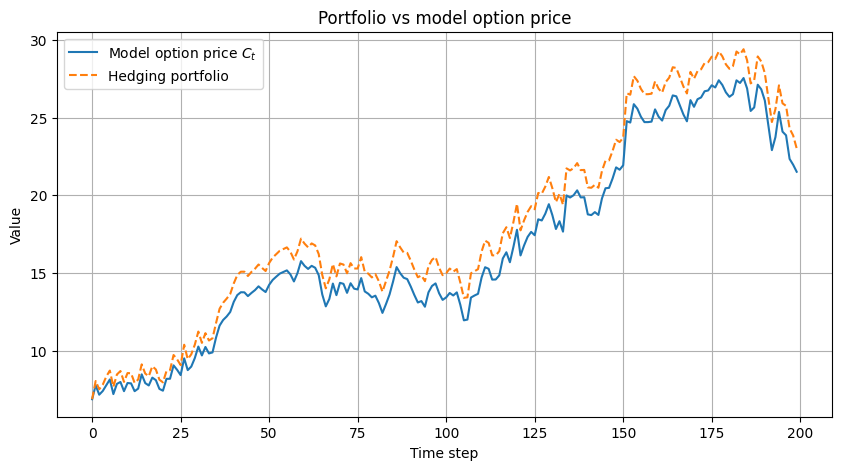

In [15]:
utils.hedging.hedge_plot(hedging_hq0_test["Price_call"][0], hedging_hq0_test["Portfolio"][0])

In [16]:
hedging_hq0_test["Portfolio"][0], hedging_hq0_test["Cash"][0]

(array([ 6.86766888,  8.04007668,  7.50758508,  7.80032657,  8.3294558 ,
         8.71142161,  7.66188667,  8.45955303,  8.68215075,  7.98380646,
         8.55081296,  8.53906445,  7.91703352,  8.13462115,  9.11153642,
         8.51927088,  8.34227584,  8.99232844,  8.7824733 ,  8.12549961,
         7.95341945,  8.67959259,  8.74121253,  9.71371729,  9.43645765,
         9.06585846, 10.37547213,  9.44903076,  9.75774765, 10.37791065,
        11.22248717, 10.49528555, 11.11942062, 10.64732422, 10.78989866,
        11.77210886, 12.69033756, 13.07821482, 13.34358393, 13.64148359,
        14.32133939, 14.86207211, 15.07644999, 15.07849426, 14.79931271,
        15.06325725, 15.26814265, 15.54040141, 15.31856227, 15.12111397,
        15.63771763, 15.98672616, 16.21032659, 16.42584934, 16.53695563,
        16.64189661, 16.3607951 , 15.85996634, 16.3916805 , 17.20505488,
        16.8837558 , 16.64373837, 16.89783772, 16.76947606, 16.21229863,
        14.86600059, 14.00633302, 14.58535932, 15.5

In [17]:
hedging_hq0_test["Price_call"][0], hedging_hq0_test["Delta"][0]

(array([ 6.86766888,  7.76958106,  7.1586049 ,  7.39627837,  7.7697954 ,
         8.14103675,  7.19862679,  7.85564336,  7.97783809,  7.38555759,
         7.91204489,  7.88655732,  7.38505963,  7.54919012,  8.46982332,
         7.90503585,  7.7531709 ,  8.2578702 ,  8.0966933 ,  7.53170103,
         7.4166777 ,  8.1786494 ,  8.18524823,  9.04687773,  8.76144024,
         8.42083861,  9.50179921,  8.74204678,  8.96780717,  9.51401777,
        10.25810035,  9.68635099, 10.23129032,  9.81662497,  9.88021031,
        10.83696607, 11.60548908, 11.96802137, 12.19260913, 12.48407078,
        13.1329753 , 13.57110263, 13.75451842, 13.74912944, 13.50638582,
        13.71003332, 13.8910756 , 14.13488252, 13.93538426, 13.76629837,
        14.23208994, 14.54760802, 14.75637467, 14.95333642, 15.06108261,
        15.16234935, 14.90560331, 14.44944866, 14.98647133, 15.75697164,
        15.4542691 , 15.25471031, 15.45417622, 15.33032051, 14.85682525,
        13.61216982, 12.84451836, 13.32241437, 14.3

## Double Heston Model

In [18]:
# --------------------------
# Module reload utility cell
# --------------------------
import importlib
import models.heston
import models.doubleheston
import plotting.plot_utils
import utils.hedging

# Reload modules to pick up edits
importlib.reload(models.heston)
importlib.reload(models.doubleheston)
importlib.reload(plotting.plot_utils)
importlib.reload(utils.hedging)

<module 'utils.hedging' from '/home/machine/Desktop/ErdosFinance2025/utils/hedging.py'>

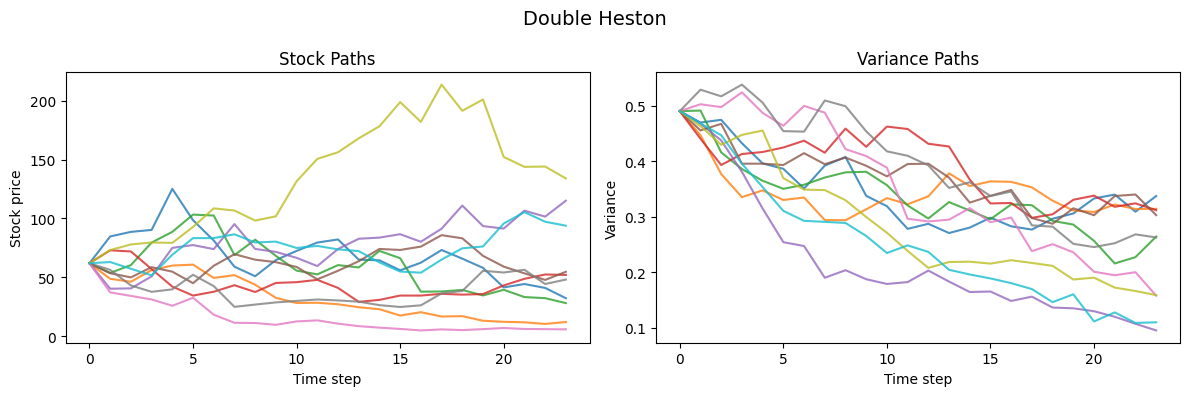

In [19]:
DoubleHeston_q0_test=models.doubleheston.DoubleHeston(r=0.03, q=0.0,
                                                   kappa1=0.9, kappa2=1.2, 
                                                   theta1=0.1, theta2=0.15, 
                                                   sigma1=0.1, sigma2=0.2, 
                                                   rho1=-0.5, rho2=-0.5)

S_dhq0_test, V1_dhq0_test, V2_dhq0_test = DoubleHeston_q0_test.simulate_paths(mu=DoubleHeston_q0_test.r,T=1, S0=61.9, 
                                                                              v01=0.6**2, v02=0.7**2,
                                                                              N_paths=10,N_steps=24, seed=20)

plotting.plot_utils.plot_paths(S_dhq0_test,V2_dhq0_test, title='Double Heston')

In [20]:
DoubleHeston_q0_test.mc_price(N_paths=100000, N_steps=1000, 
                           K=61.9, T=1, S0=61.9, v01=0.6**2, v02=0.7**2, seed=20)

np.float64(19.43242138500229)

In [21]:
DoubleHeston_q0_test.cf_price(Lphi=0.0000001, Uphi=100, dphi=0.0001, 
                           K=61.9, tau=1, S=61.9, v1=0.6**2, v2=0.7**2)

np.float64(19.45378032050505)

In [22]:
# Compares with cf_price and the value in Rouah's book for delta (0.6730), price call = 19.4538
DoubleHeston_q0_test.price_greeks(Lphi=0.0000001, Uphi=100, dphi=0.0001, 
                               K=61.9, tau=1, S=61.9, v1=0.6**2, v2=0.7**2)

{'call_price': np.float64(19.45378032050505),
 'delta': np.float64(0.6729675032920192)}

In [23]:
hedging_dhq0_test=utils.hedging.delta_hedge(mu=DoubleHeston_q0_test.r,model=DoubleHeston_q0_test, 
                                            K=61.9, T=1, S0=61.9, v01=0.6**2, v02=0.7**2, 
                                            N_paths=4,N_steps=200, seed=20)
                                           #quad_params={'Lphi':1e-5,'Uphi':50,'dphi':0.01})

laguerre quadrature rule with parameters: nodes=32
1.0150565989004465 1.5845590796557927


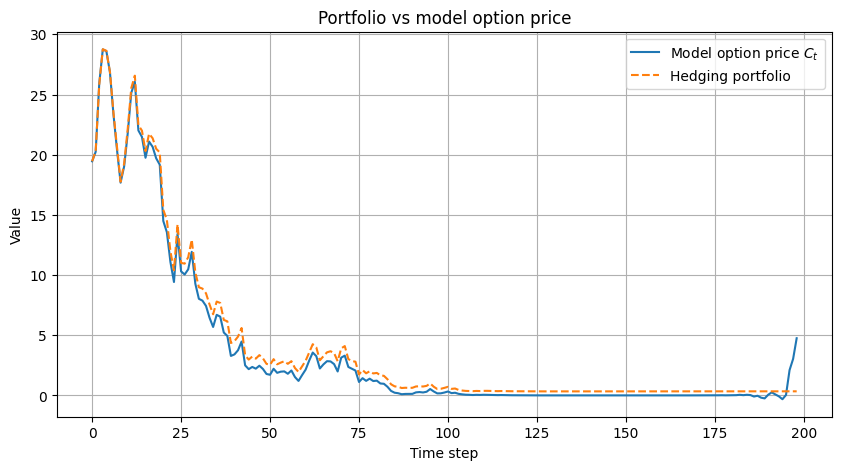

In [24]:
utils.hedging.hedge_plot(hedging_dhq0_test["Price_call"][0][:-1], hedging_dhq0_test["Portfolio"][0][:-1])

In [25]:
hedging_dhq0_test["Portfolio"][0], hedging_dhq0_test["Cash"][0]

(array([19.45378152, 20.30971146, 25.81984121, 28.7669048 , 28.63780161,
        26.8937149 , 23.46793024, 20.58292939, 17.75828392, 19.27004583,
        22.14554317, 25.531829  , 26.57055539, 22.46158042, 21.99864038,
        20.29997612, 21.74591518, 21.37268062, 20.49506033, 20.19124706,
        15.41952028, 14.59245753, 11.96394465, 10.39606039, 14.21103976,
        11.01453252, 10.94866037, 11.47979367, 12.94535761, 10.22877492,
         8.98938065,  8.87378035,  8.48409913,  7.55467065,  6.7422527 ,
         7.79793098,  7.67946235,  6.27475241,  6.15199692,  4.3544067 ,
         4.50814012,  4.88595841,  5.59988929,  3.34351375,  2.97500098,
         3.22806305,  3.0540511 ,  3.3474452 ,  3.08133122,  2.61983419,
         2.5445702 ,  3.01034417,  2.58387413,  2.72293135,  2.83890436,
         2.62447581,  2.84498555,  2.27357473,  1.94853308,  2.4139838 ,
         2.87665453,  3.5701807 ,  4.25360932,  3.98850999,  2.91533055,
         3.25374493,  3.57701134,  3.66915758,  3.5

In [26]:
hedging_dhq0_test["Price_call"][0], hedging_dhq0_test["Delta"][0]

(array([ 1.94537815e+01,  2.02432338e+01,  2.59283940e+01,  2.87511532e+01,
         2.86076201e+01,  2.68708062e+01,  2.33372664e+01,  2.03804765e+01,
         1.76795167e+01,  1.90351443e+01,  2.17677929e+01,  2.51370853e+01,
         2.60669744e+01,  2.20163053e+01,  2.14812311e+01,  1.97461276e+01,
         2.10916699e+01,  2.06554323e+01,  1.97019810e+01,  1.91758681e+01,
         1.44918751e+01,  1.35661964e+01,  1.10913505e+01,  9.42335392e+00,
         1.34113805e+01,  1.03046966e+01,  1.00471625e+01,  1.04752890e+01,
         1.19286515e+01,  9.28508109e+00,  8.02623292e+00,  7.87442064e+00,
         7.43663102e+00,  6.44860066e+00,  5.68652821e+00,  6.69429737e+00,
         6.54454505e+00,  5.22602796e+00,  4.94023224e+00,  3.27909003e+00,
         3.40780267e+00,  3.75221468e+00,  4.47436146e+00,  2.49529515e+00,
         2.18179260e+00,  2.36378382e+00,  2.22240745e+00,  2.46667476e+00,
         2.19721822e+00,  1.78043096e+00,  1.71310989e+00,  2.21196406e+00,
         1.8

### Monte Carlo Simulations (Double Heston)

#### Brownian motions

Describe how the Brownian motions are simulated.

#### Euler Scheme (Double Heston)

Describe the Euler scheme for the SDEs.

#### Simulations (Double Heston)

In [27]:
#Code goes here
# simulate_paths(S0, v0_1, v0_2, r, kappa1, theta1, sigma1, rho1,kappa2, theta2, sigma2, rho2, rho12, T, N_steps, N_paths)
# mc_price(S_paths, K, r, T, option_type='call')

In [28]:
# Path simulations

### Exact Price (Double Heston)

Formulas go here.

In [29]:
# Code goes here
# dobleheston_cf_price(S0,v0_1, v0_2,r,kappa1, theta1, sigma1, rho1,
# kappa2, theta2, sigma2, rho2,rho12,T, K) # not so sure about the arguments for this one, but we'll find out

In [30]:
# Comparison between Monte Carlo and exact price

## References

Heston, S.L., 1993. A closed-form solution for options with stochastic volatility with applications to bond and currency options. The review of financial studies, 6(2), pp.327-343.

Rouah, F.D., 2013. The Heston model and its extensions in Matlab and C. John Wiley & Sons.